In [1]:
import os, sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random
import copy


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

In [6]:
Zoom=13
CALCULATOR = dgckernel.Calculator()
CALCULATOR.SetLayer(Zoom)

'''GRID ID'''

def get_grid(lng,lat):

    return CALCULATOR.HexCellKey(dgckernel.GeoCoord(lat, lng))

'''GRID SHAPE'''

def get_grid_shape(grid):

    return CALCULATOR.HexCellVertexesAndCenter(grid)

'''Neighbor Grid'''

def grid_neighbor(grid, low_layer, up_layer):

    neighbors = CALCULATOR.HexCellNeighbor(grid, up_layer)
    _neighbors = CALCULATOR.HexCellNeighbor(grid, low_layer)
    neighbors = [e for e in neighbors if e not in _neighbors]
    return neighbors

'''获取一定范围内的格子'''

def grid_eliminate(grid_list,sw,ne):
    grid_result=list()
    for grid in grid_list:
        v_f,c_f=get_grid_shape(grid)
        c_lng,c_lat=c_f.lng,c_f.lat;
        if c_lng>=sw[1] and c_lng<=ne[1] and c_lat>=sw[0] and c_lat<=ne[0]:
            grid_result.append(grid)
    return grid_result

'''经纬度距离转直线距离'''

def Geo_distance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) 
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    distance=2*asin(sqrt(a))*6371 
    distance=round(distance,2)
    return distance


'''获取格子之间的路面距离'''

def get_grid_dis(f_grid,t_grid):
    
    f_shape,f_center=get_grid_shape(f_grid);
    t_shape,t_center=get_grid_shape(t_grid);
    
    Topology_dis=1.3*Geo_distance(f_center.lng,f_center.lat,t_center.lng,t_center.lat)
    
    return Topology_dis



'''Time stamp'''
def stamp_transit(time_str):
    timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    timeStamp = int(time.mktime(timeArray))
    return timeStamp
    
'''Time step'''

def stamp_to_step(timestamp,date_str,step):
    baseline = date_str+" 00:00:00";
    baseline = int(stamp_transit(baseline))
    current_step=int((timestamp-baseline)/step)
    return current_step

'''Drawing'''

def draw_bkg(sw,ne):
    
    '''Initial parameter'''
    bg_path='Chengdu_sample.png'
    
    '''Figure out'''
    img = plt.imread(bg_path)
    height, width = img.shape[:2]
    h1 = math.ceil(15./width*height)
    fig = plt.figure(figsize=(15,h1))
    ax = fig.add_subplot(111)
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    plt.xlim(xgrange)
    plt.ylim(ygrange)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.xticks(np.arange(xgrange[0], xgrange[1], 0.352/15))
    plt.yticks(np.arange(ygrange[0], ygrange[1], 0.2415/13))
    try:
        ax.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
    except:
        pass
    return fig, ax, xgrange, ygrange

# 0 Data initializing

In [3]:
'''Real Data Extracting'''

'''Request data'''

date_str='2016-11-01'

Request_data=pd.read_csv('Dataset/order_20161101.csv',header=None,\
                            names = ['Order_ID','Start_time','Stop_time','Pickup_Longitude','Pickup_Latitude',\
                                    'Dropoff_Longitude','Dropoff_Latitude','Reward_unit'])

Request_data['Pickup_Gird']=Request_data.apply(lambda x:get_grid(x['Pickup_Longitude'],x['Pickup_Latitude']),axis=1)

Request_data['Dropoff_Gird']=Request_data.apply(lambda x:get_grid(x['Dropoff_Longitude'],x['Dropoff_Latitude']),axis=1)

Request_data['Pickup_step']=Request_data.apply(lambda x:stamp_to_step(x['Start_time'],date_str,300), axis=1)

Request_data['Dropoff_step']=Request_data.apply(lambda x:stamp_to_step(x['Stop_time'],date_str,300), axis=1)

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

'''Trajectory data'''


Tracectory_data=pd.read_csv('./Experiments/Demo/gps20161101.csv')

Tracectory_data=Tracectory_data.drop(columns=['Unnamed: 0'])

Tracectory_data.columns = ['Driver_ID','Order_ID','Dispatch_step','lng','lng','Dispatch_Grid']

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step']].merge(Request_data[['Order_ID','Pickup_Gird']],on='Order_ID')


'''Idle_Transition data'''


Idle_Transition=pd.read_csv('Dataset/idle_transition_probability.csv',header=None,\
                            names = ['Hour','Origin_grid','Dest_grid','Prob'])

'''Grid noting'''

Grid_notes=pd.read_csv('./Experiments/Demo/hexagon_grid_table.csv',header=None,
                            names = ['Grid_id','v1_lng','v1_lat',\
                                    'v2_lng','v2_lat',\
                                    'v3_lng','v3_lat',\
                                    'v4_lng','v4_lat',\
                                    'v5_lng','v5_lat',\
                                    'v6_lng','v6_lat'])

Grid_notes=Grid_notes.dropna(subset=['v1_lng','v1_lat',\
                                    'v2_lng','v2_lat',\
                                    'v3_lng','v3_lat',\
                                    'v4_lng','v4_lat',\
                                    'v5_lng','v5_lat',\
                                    'v6_lng','v6_lat'])

Grid_notes['c_lng']=Grid_notes.apply(lambda x:(x['v1_lng']+x['v2_lng']+x['v3_lng']\
                                                               +x['v4_lng']+x['v5_lng']+x['v6_lng'])/6,axis=1)

Grid_notes['c_lat']=Grid_notes.apply(lambda x:(x['v1_lat']+x['v2_lat']+x['v3_lat']\
                                                               +x['v4_lat']+x['v5_lat']+x['v6_lat'])/6,axis=1)

Grid_notes=Grid_notes[['Grid_id','c_lng','c_lat']]

Grid_notes['grid']=Grid_notes.apply(lambda x:get_grid(x['c_lng'],x['c_lat']), axis=1)


Idle_Transition=Idle_Transition.merge(Grid_notes[['Grid_id','grid']],left_on='Origin_grid', right_on='Grid_id')

Idle_Transition=Idle_Transition[['Hour','grid','Dest_grid','Prob']]

Idle_Transition=Idle_Transition.rename(index=str, columns={"grid": "Origin_grid"})

Idle_Transition=Idle_Transition.merge(Grid_notes[['Grid_id','grid']],left_on='Dest_grid', right_on='Grid_id')

Idle_Transition=Idle_Transition[['Hour','Origin_grid','grid','Prob']]

Idle_Transition=Idle_Transition.rename(index=str, columns={"grid": "Dest_grid"})


# 01 Modeling

In [7]:
'''Overall range'''
# southwest=[30.331759, 103.512892]
# northeast=[30.944065, 104.640393]

'''Sample range'''

southwest=[30.617149, 104.014056]
northeast=[30.698437, 104.128742]

'''Time range'''

end_step=288


lng,lat=104.066218,30.656725
sample_grid=get_grid(lng,lat)
All_grid = grid_neighbor(sample_grid, 0, 70)
All_grid.append(sample_grid)
All_grid=grid_eliminate(All_grid,southwest,northeast)
Grid_range=pd.DataFrame(All_grid,columns=['grid'])


'''Data filtering'''

'''Request_data'''

Request_data=Request_data.merge(Grid_range,left_on='Pickup_Gird',right_on='grid')

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

Request_data=Request_data.merge(Grid_range,left_on='Dropoff_Gird',right_on='grid')

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

'''Tracectory_data'''

Tracectory_data=Tracectory_data.drop_duplicates(subset=['Driver_ID','Order_ID'], keep='first')

Tracectory_data=Tracectory_data.merge(Grid_range,left_on='Dispatch_Grid',right_on='grid')

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step','Pickup_Gird']]

Tracectory_data=Tracectory_data.merge(Grid_range,left_on='Pickup_Gird',right_on='grid')

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step','Pickup_Gird']]

'''Grid Screening'''

Idle_Transition=Idle_Transition.merge(Grid_range,left_on='Origin_grid',right_on='grid')

Idle_Transition=Idle_Transition[['Hour','Origin_grid','Dest_grid','Prob']]

Idle_Transition=Idle_Transition.merge(Grid_range,left_on='Dest_grid',right_on='grid')

Idle_Transition=Idle_Transition[['Hour','Origin_grid','Dest_grid','Prob']]

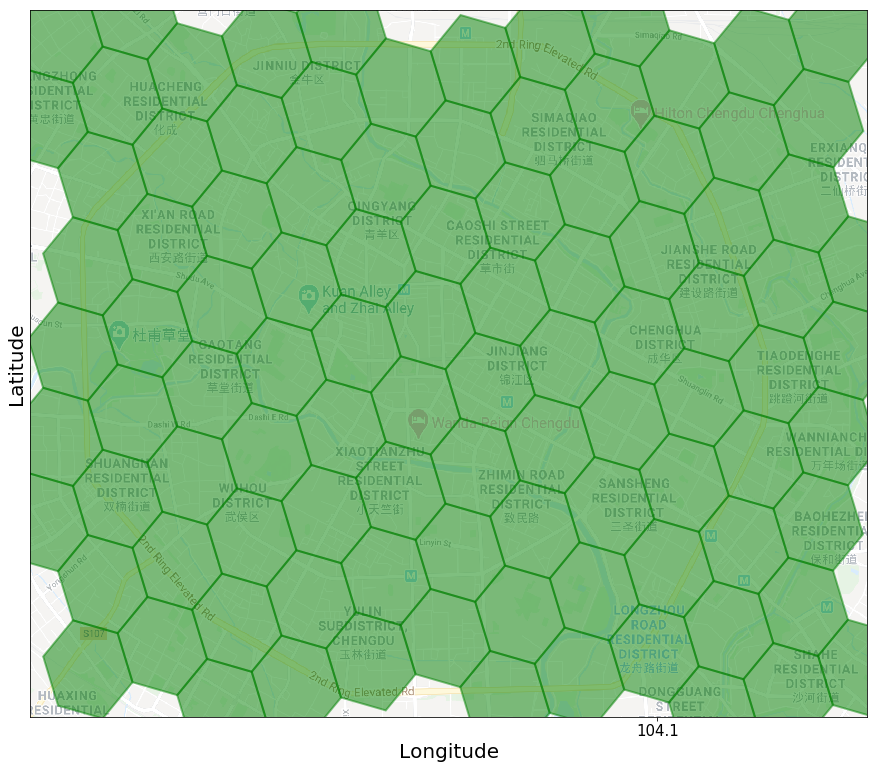

In [8]:
fig, ax, xgrange, ygrange=draw_bkg(southwest,northeast)

'''Axis'''

xmajorLocator   = MultipleLocator(0.1)
ymajorLocator   = MultipleLocator(0.1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)

for idx,row in Grid_range.iterrows():
    
    grid=row['grid']


    v_f,c_f=get_grid_shape(grid)


    pgon = plt.Polygon(([v_f[0].lng,v_f[0].lat], [v_f[1].lng,v_f[1].lat], [v_f[2].lng,v_f[2].lat]\
                            ,[v_f[3].lng,v_f[3].lat],[v_f[4].lng,v_f[4].lat],[v_f[5].lng,v_f[5].lat]),color='g',linewidth=2,fill=True,alpha=0.5)

    plt.gca().add_patch(pgon)


plt.tick_params(labelsize=15)

labels = ax.get_xticklabels() + ax.get_yticklabels()
font2 = {'weight': 'normal','size': 20}
plt.xlabel('Longitude', font2)
plt.ylabel('Latitude', font2)
plt.xlim((southwest[1], northeast[1]))
plt.ylim((southwest[0], northeast[0]))

plt.show()

In [9]:
'''State'''

State=list()
for grid in All_grid:
    for t_step in range(end_step):
        State.append(str(grid)+'-'+str(t_step))
        
State_range=pd.DataFrame(State,columns=['State'])



In [11]:
'''Action'''

Action_space={}

for idx,row in Grid_range.iterrows():
    
    grid=row['grid']
    
    for t_step in range(end_step):
        
        hour=int(t_step/12)
        
        state=grid+'-'+str(t_step)
        
        Action_candidate=grid_neighbor(grid, 0, 1)+[grid]
        
        Action_list=grid_eliminate(Action_candidate,southwest,northeast)
        
        Action_space[state]=Action_list
        

In [12]:
'''Macth probability'''

Match_PROB=Request_data.groupby(['Pickup_Gird','Pickup_step']).count()[['Order_ID']]

Match_PROB['Transition']=Match_PROB.index

Match_PROB['Pickup_Gird']=Match_PROB.apply(lambda x:x['Transition'][0],axis=1)

Match_PROB['Pickup_step']=Match_PROB.apply(lambda x:x['Transition'][1],axis=1)

Match_PROB=Match_PROB.reset_index(drop=True)

Match_PROB=Match_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Match_PROB=Match_PROB[['Pickup_Gird','Pickup_step','Order_Cnt']]

Match_PROB['State']=Match_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Match_PROB['Prob']=Match_PROB.apply(lambda x:round(x['Order_Cnt']/4.0,2) if x['Order_Cnt']<=4 else 1.00,axis=1)

Match_PROB=Match_PROB[['State','Prob']]

Match_PROB=State_range.merge(Match_PROB,on='State',how='left')

Match_PROB=Match_PROB.fillna(0.0)

Match_PROB_Dic={}

for idx,row in Match_PROB.iterrows():
    
    Match_PROB_Dic[row['State']]=row['Prob']
    


In [13]:

'''Trajectory merging'''

Dispatch_PROB=Tracectory_data.groupby(['Dispatch_Grid','Dispatch_step','Pickup_Gird']).count()[['Order_ID']]

Dispatch_PROB['Transition']=Dispatch_PROB.index

Dispatch_PROB['Dispatch_Grid']=Dispatch_PROB.apply(lambda x:x['Transition'][0],axis=1)

Dispatch_PROB['Dispatch_step']=Dispatch_PROB.apply(lambda x:x['Transition'][1],axis=1)

Dispatch_PROB['Pickup_Gird']=Dispatch_PROB.apply(lambda x:x['Transition'][2],axis=1)

Dispatch_PROB=Dispatch_PROB.reset_index(drop=True)

Dispatch_PROB=Dispatch_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Dispatch_PROB=Dispatch_PROB[['Dispatch_Grid','Dispatch_step','Pickup_Gird','Order_Cnt']]


'''Temp'''

TEMP=Tracectory_data.groupby(['Dispatch_Grid','Dispatch_step']).count()[['Order_ID']]

TEMP['Transition']=TEMP.index

TEMP['Dispatch_Grid']=TEMP.apply(lambda x:x['Transition'][0],axis=1)

TEMP['Dispatch_step']=TEMP.apply(lambda x:x['Transition'][1],axis=1)

TEMP=TEMP.reset_index(drop=True)

TEMP=TEMP.rename(index=str, columns={"Order_ID": "Order_Sum"})

TEMP=TEMP[['Dispatch_Grid','Dispatch_step','Order_Sum']]

Dispatch_PROB=Dispatch_PROB.merge(TEMP,on=['Dispatch_Grid','Dispatch_step'])

Dispatch_PROB['Prob']=Dispatch_PROB.apply(lambda x:round(float(x['Order_Cnt']/x['Order_Sum']),2),axis=1)

Dispatch_PROB=Dispatch_PROB[['Dispatch_Grid','Dispatch_step','Pickup_Gird','Prob']]

Dispatch_PROB['Pickup_step']=Dispatch_PROB.apply(lambda x:x['Dispatch_step']+1,axis=1)

Dispatch_PROB['Dispatch_state']=Dispatch_PROB.apply(lambda x:x['Dispatch_Grid']+'-'+str(x['Dispatch_step']),axis=1)

Dispatch_PROB['Pickup_state']=Dispatch_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Dispatch_PROB=Dispatch_PROB[['Dispatch_state','Pickup_state','Prob']]

Dispatch_PROB_Dic={}

for idx,row in Dispatch_PROB.iterrows():
    
    if row['Dispatch_state'] not in Dispatch_PROB_Dic.keys():
    
        Dispatch_PROB_Dic[row['Dispatch_state']]={}
        
        Dispatch_PROB_Dic[row['Dispatch_state']][row['Pickup_state']]=row['Prob']
        
    else:
        
        Dispatch_PROB_Dic[row['Dispatch_state']][row['Pickup_state']]=row['Prob']
        

            

In [14]:
'''Cancel Probability'''

Cancel_Transition=pd.read_csv('Dataset/order_20161101_cancel_prob.csv',header=None,\
                            names = ['Order_id']+['pickup_dis'+str(i) for i in range(200,2200,200)])

Cancel_dic={}

for i in range(200,2200,200):
    
    Cancel_dic[i]=np.mean(Cancel_Transition['pickup_dis'+str(i)])
    
     

In [15]:
'''Request Distribution'''

Request_PROB=Request_data.groupby(['Pickup_Gird','Pickup_step','Dropoff_Gird']).count()[['Order_ID']]

Request_PROB['Transition']=Request_PROB.index

Request_PROB['Pickup_Gird']=Request_PROB.apply(lambda x:x['Transition'][0],axis=1)

Request_PROB['Pickup_step']=Request_PROB.apply(lambda x:x['Transition'][1],axis=1)

Request_PROB['Dropoff_Gird']=Request_PROB.apply(lambda x:x['Transition'][2],axis=1)

Request_PROB=Request_PROB.reset_index(drop=True)

Request_PROB=Request_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Request_PROB=Request_PROB[['Pickup_Gird','Pickup_step','Dropoff_Gird','Order_Cnt']]


TEMP=Request_data.groupby(['Pickup_Gird','Pickup_step']).count()[['Order_ID']]

TEMP['Transition']=TEMP.index

TEMP['Pickup_Gird']=TEMP.apply(lambda x:x['Transition'][0],axis=1)

TEMP['Pickup_step']=TEMP.apply(lambda x:x['Transition'][1],axis=1)

Request_PROB=Request_PROB.reset_index(drop=True)

TEMP=TEMP.rename(index=str, columns={"Order_ID": "Order_Sum"})

TEMP=TEMP.reset_index(drop=True)

TEMP=TEMP[['Pickup_Gird','Pickup_step','Order_Sum']]

Request_PROB=Request_PROB.merge(TEMP,on=['Pickup_Gird','Pickup_step'])

Request_PROB['Prob']=Request_PROB.apply(lambda x:round(float(x['Order_Cnt']/x['Order_Sum']),2),axis=1)

Request_PROB=Request_PROB[['Pickup_Gird','Pickup_step','Dropoff_Gird','Prob']]

Request_PROB['Dropoff_step']=Request_PROB.apply(lambda x:int(x['Pickup_step'])+math.ceil(get_grid_dis(x['Pickup_Gird'],x['Dropoff_Gird'])/3),axis=1)

Request_PROB['Pickup_state']=Request_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Request_PROB['Dropoff_state']=Request_PROB.apply(lambda x:x['Dropoff_Gird']+'-'+str(x['Dropoff_step']),axis=1)

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB=Request_PROB.merge(State_range,left_on='Pickup_state',right_on='State')

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB=Request_PROB.merge(State_range,left_on='Dropoff_state',right_on='State')

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB

Request_PROB_Dic={}

for idx,row in Request_PROB.iterrows():
    
    if row['Pickup_state'] not in Request_PROB_Dic.keys():
    
        Request_PROB_Dic[row['Pickup_state']]={}
        
        Request_PROB_Dic[row['Pickup_state']][row['Dropoff_state']]=row['Prob']
        
    else:
        
        Request_PROB_Dic[row['Pickup_state']][row['Dropoff_state']]=row['Prob']
        



In [16]:
'''Gain data'''

Gain_table=Request_data.groupby(['Pickup_Gird','Pickup_step']).mean()[['Reward_unit']]

Gain_table['Transition']=Gain_table.index

Gain_table['Pickup_Gird']=Gain_table.apply(lambda x:x['Transition'][0],axis=1)

Gain_table['Pickup_step']=Gain_table.apply(lambda x:x['Transition'][1],axis=1)

Gain_table=Gain_table.reset_index(drop=True)

Gain_table=Gain_table[['Pickup_Gird','Pickup_step','Reward_unit']]

Gain_table['Pickup_state']=Gain_table.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Gain_table=Gain_table[['Pickup_state','Reward_unit']]

Gain_table=State_range.merge(Gain_table,left_on='State',right_on='Pickup_state',how='left')

Gain_table=Gain_table[['State','Reward_unit']]

Gain_table=Gain_table.fillna(0.0)

Gain_table_Dic={}

for idx,row in Gain_table.iterrows():
    
    Gain_table_Dic[row['State']]=row['Reward_unit']



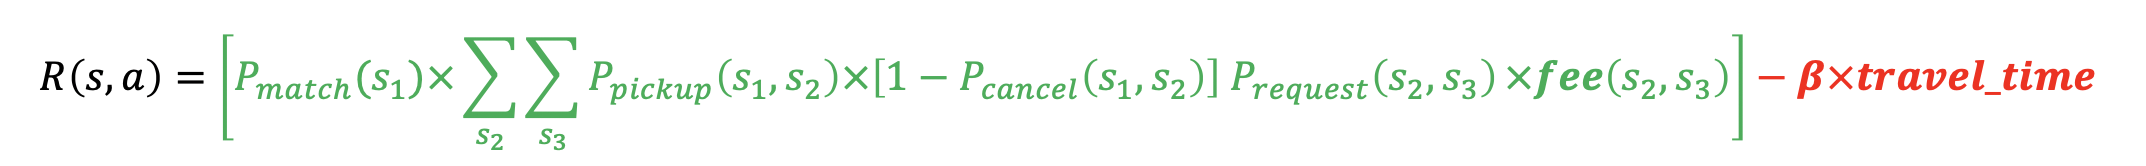

In [18]:
'''Reward'''

beta=5

Reward={}

for state in State:
    
    Reward[state]={}
    
    current_grid=state.split('-')[0];
    
    current_stamp=int(state.split('-')[1])

    for action in Action_space[state]:

        next_grid=action
        
        next_stamp=int(current_stamp)+1
        
        next_state=str(next_grid)+'-'+str(next_stamp)

        if next_stamp<end_step:

            '''基于预估旅行时间的空驶成本'''

            cruise_cost=beta*1

            '''S1的匹配概率'''
            
            Prob=Match_PROB_Dic[next_state]
            
            gain=0
            
            '''在S2接单的概率'''
            
            if next_state in Dispatch_PROB_Dic.keys():
                
                for pickup_state,pickup_prob in Dispatch_PROB_Dic[next_state].items():
                    
                    pickup_stamp=int(pickup_state.split('-')[1])
                    
                    if pickup_stamp<end_step:
                        
                        pickup_award=Gain_table_Dic[pickup_state]

                        gain+=pickup_prob*pickup_award
        
            pickup_order=Prob*gain

            Reward[state][action]=round(pickup_order-cruise_cost,2)
            
       

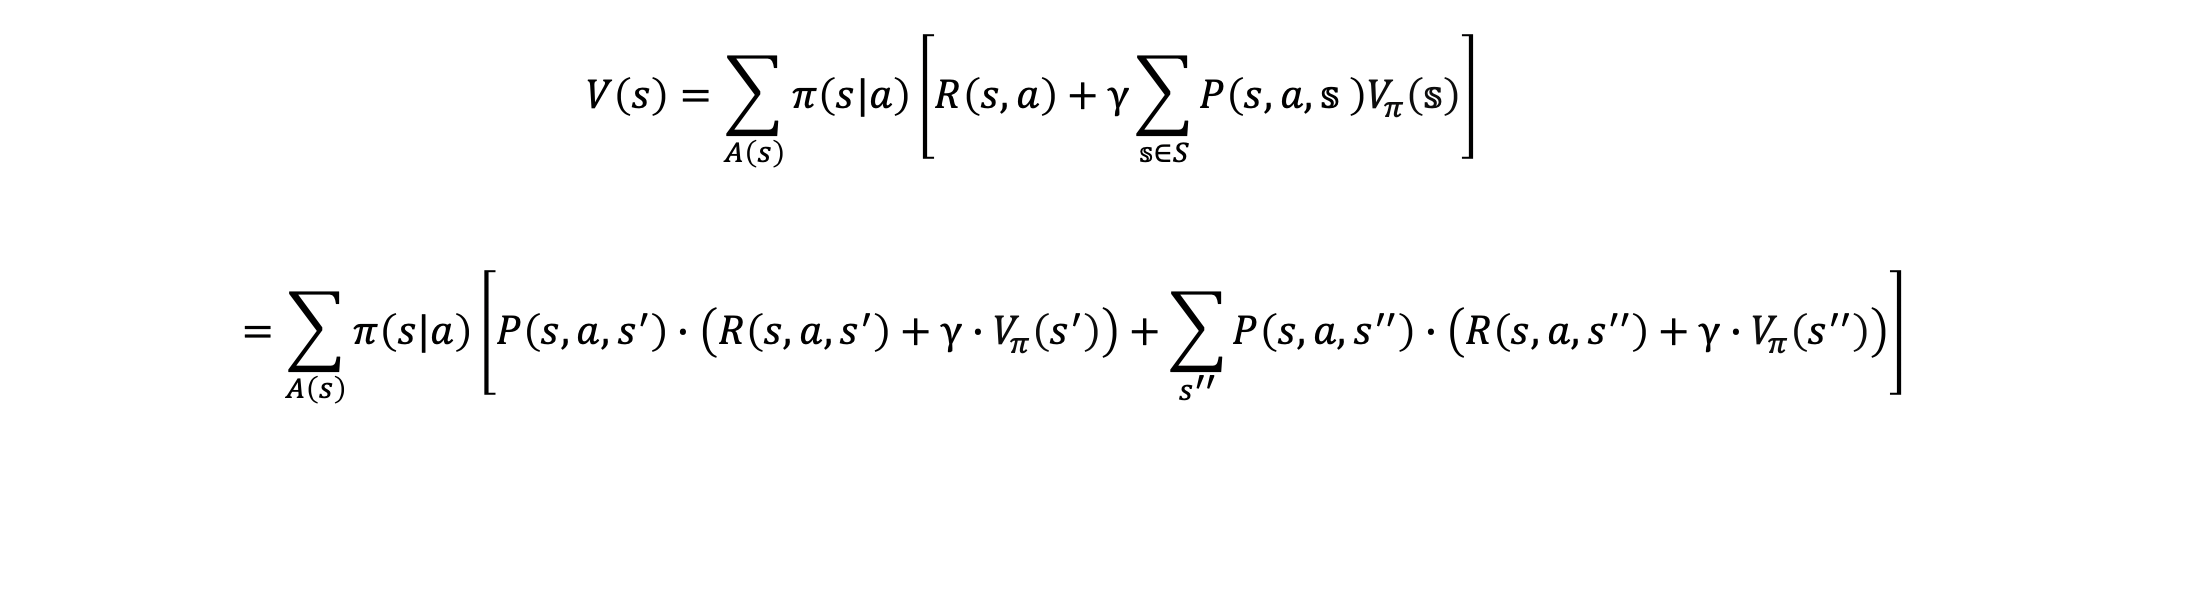

In [19]:
def Bellman(state,A_set,State_value,Match_PROB_Dic,Dispatch_PROB_Dic,Request_PROB_Dic,Reward,gumma):
    
    '''获取当前位置和时间步'''
    current_grid=state.split('-')[0]
    current_stamp=int(state.split('-')[1])
    
    '''贝尔曼方程迭代'''
    
    Action_prob=round(float(1)/len(A_set[state]),3)
    
    V=0
    
    for action in A_set[state]:
        
        next_grid=action
        next_stamp=int(current_stamp+1)
        next_state=next_grid+'-'+str(next_stamp)
        
        if next_stamp>=end_step:
            
            continue
        
        '''定义当前的reward'''
        
        R=Action_prob*Reward[state][action]
        
        '''若司机未能接到单'''
        
        match_prob=Match_PROB_Dic[next_state]
        
        V_=(1-Prob)*State_value[next_state]
        
        '''若司机可以接到单'''
        
        if next_state in Dispatch_PROB_Dic.keys():
            
            for pickup_state,pickup_prob in Dispatch_PROB_Dic[next_state].items():
                    
                    if pickup_state in Request_PROB_Dic.keys():
                        
                        for dest_state,request_prob in Dispatch_PROB_Dic[next_state].items():
                            
                            dest_time=int(dest_state.split('-')[1])
                            
                            if dest_time<end_step:
                        
                                V_+=match_prob*pickup_prob*request_prob*State_value[dest_state]
                            
        V+= R+ Action_prob*gumma*V_                 
        
    return V

'''基于Greedy的动作选择'''

def Update_action(State_value,A_set):
    
    '''Greedy筛选动作'''
    
    for state,action_list in A_set.items():
        
        Next_value={}
        
        current_grid=state.split('-')[0]
        
        current_stamp=int(state.split('-')[1])
        
        for action in action_list:
            
            next_grid=action
            
            next_stamp=int(current_stamp+1)
            
            next_state=next_grid+'-'+str(next_stamp)
            
            if next_stamp>=end_step:
            
                continue
            
            Next_value[action]=State_value[next_state]
            
        if len(Next_value)!=0:
        
            Max_value=max(Next_value.values())

            for action,action_value in Next_value.items():

                if action_value<Max_value:

                    A_set[state].remove(action)
                
    return A_set

In [20]:
'''定义初始状态，所有状态价值为0'''

State_value={state:0 for state in State}
diff=0
Value_record={}
Origin_policy=copy.deepcopy(Action_space)
pre_V_sum=0
iteration=100
gumma=0.8

for i in range(iteration):

    for state in State:

        State_value[state]=Bellman(state,Origin_policy,State_value,Match_PROB_Dic,Dispatch_PROB_Dic,Request_PROB_Dic,Reward,gumma)

    Value_record[i]=sum(State_value.values())

    Origin_policy=Update_action(State_value,Origin_policy)

    diff=abs(Value_record[i]-pre_V_sum)

    if diff<5:

        break

    pre_V_sum=Value_record[i]

Optimal_policy=Origin_policy



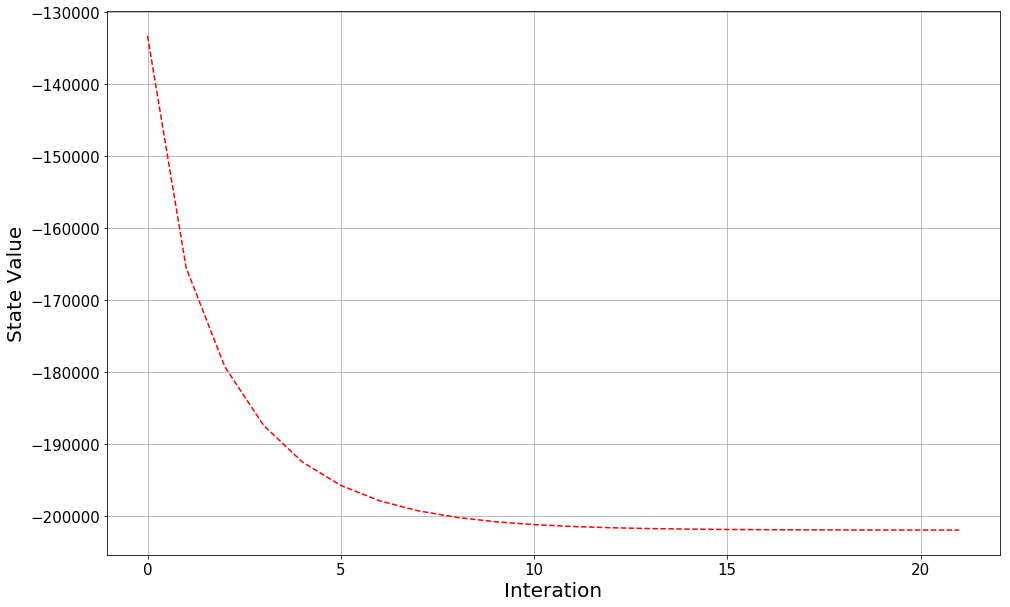

In [21]:
figsize = 16,10
figure,ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
font = {'weight' : 'normal','size': 20}

plt.plot(Value_record.keys(),Value_record.values(),'r--')
plt.xlabel('Interation',font)
plt.ylabel('State Value',font)
plt.grid()
plt.show()

In [22]:
Policy_table=pd.DataFrame(Optimal_policy.keys(),columns=['State'])
Policy_table['Policy']=Optimal_policy.values()
Policy_table[['State']] = Policy_table[['State']].astype(str)
Policy_table['grid']=Policy_table.apply(lambda x:x['State'].split('-')[0],axis=1)
Policy_table['stamp']=Policy_table.apply(lambda x:int(x['State'].split('-')[1]),axis=1)
Policy_table['Policy']=Policy_table.apply(lambda x:x['Policy'][0],axis=1)
Policy_table=Policy_table[['stamp','grid','Policy']]


In [23]:
Weight=Match_PROB

Weight['grid']=Weight.apply(lambda x:x['State'].split('-')[0],axis=1)

Weight['stamp']=Weight.apply(lambda x:int(x['State'].split('-')[1]),axis=1)

Weight=Weight[['grid','stamp','Prob']]

stamp=120

Sample=Policy_table.loc[Policy_table['stamp']==stamp]

Weight=Weight.loc[Weight['stamp']==stamp]

Sample=Sample.merge(Weight[['grid','Prob']],on='grid')

Sample['weight'] = 0.5*Sample['Prob'] 

Sample

,stamp,grid,Policy,Prob,weight
0,120,OL13F1i6602j1654,OL13F1i6602j1653,0.75,0.375
1,120,OL13F1i6602j1653,OL13F1i6601j1653,1.00,0.500
2,120,OL13F1i6601j1653,OL13F1i6601j1653,1.00,0.500
3,120,OL13F1i6600j1654,OL13F1i6601j1653,1.00,0.500
4,120,OL13F1i6600j1655,OL13F1i6600j1654,1.00,0.500
5,120,OL13F1i6601j1655,OL13F1i6600j1655,1.00,0.500
6,120,OL13F1i6603j1654,OL13F1i6602j1654,1.00,0.500
7,120,OL13F1i6603j1653,OL13F1i6602j1653,1.00,0.500
8,120,OL13F1i6603j1652,OL13F1i6602j1652,0.50,0.250
9,120,OL13F1i6602j1652,OL13F1i6601j1653,1.00,0.500


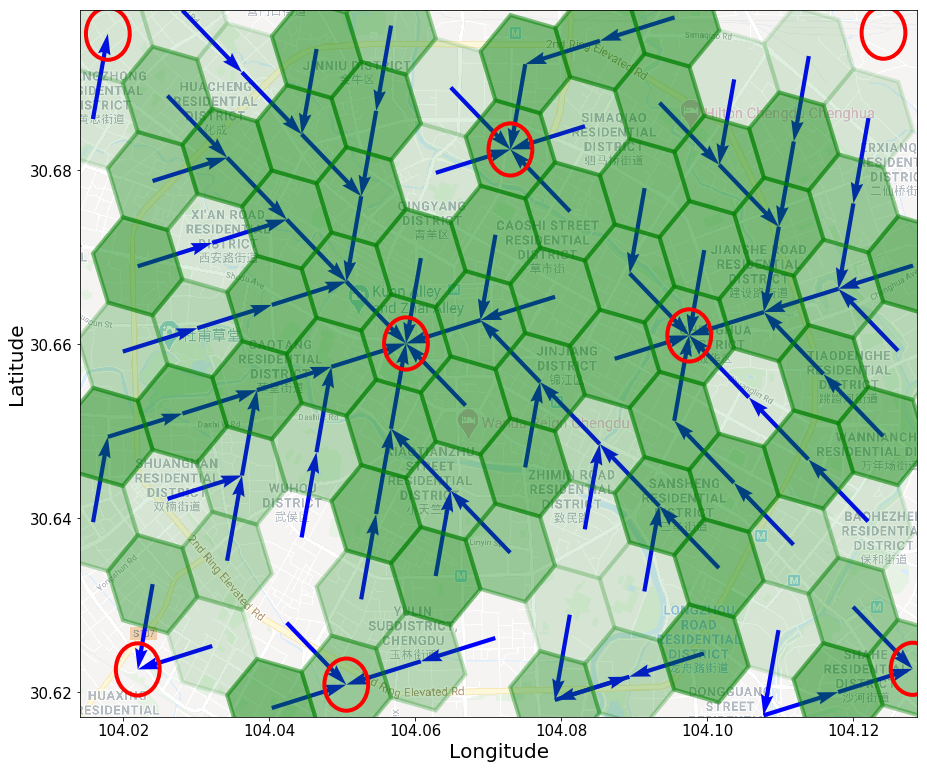

In [24]:
'''2 绘制网络连通性'''

fig, ax, xgrange, ygrange=draw_bkg(southwest,northeast)

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 15}
font_title = {'family' : 'Times New Roman','weight' : 'normal','size': 30}

    
for idx,row in Sample.iterrows():
    
    pre_grid=row['grid']
    grid=row['Policy']
    
    vv_f,cc_f=get_grid_shape(pre_grid)
    v_f,c_f=get_grid_shape(grid)
    
    pgon = plt.Polygon(([vv_f[0].lng,vv_f[0].lat], [vv_f[1].lng,vv_f[1].lat], [vv_f[2].lng,vv_f[2].lat]\
                            ,[vv_f[3].lng,vv_f[3].lat],[vv_f[4].lng,vv_f[4].lat],[vv_f[5].lng,vv_f[5].lat]),color='g',linewidth=4,fill=True,alpha=row['weight'])

    plt.gca().add_patch(pgon)

    X_1 =round(cc_f.lng,5)
    Y_1 =round(cc_f.lat,5)
    X_2 =round(c_f.lng,5)
    Y_2=round(c_f.lat,5)
    
    U = round(X_2-X_1,5)
    V = round(Y_2-Y_1,5)


        
    if pre_grid==grid:
        
        cir=Circle(xy = (X_1,Y_1), radius=0.003, alpha=1,color = 'red',linewidth=4, fill = False)

        ax.add_patch(cir)
        
    else:

        plt.quiver(X_1,Y_1,U,V, angles='xy', scale_units='xy', scale=1,color='b',width=.005,headwidth=3,alpha=1,linestyle='--')
        



'''设置坐标轴刻度'''

xmajorLocator   = MultipleLocator(0.02)
ymajorLocator   = MultipleLocator(0.02) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)


plt.tick_params(labelsize=15)
font2 = {'weight': 'normal','size': 20}
plt.xlabel('Longitude', font2)
plt.ylabel('Latitude', font2)
plt.xlim((southwest[1], northeast[1]))
plt.ylim((southwest[0], northeast[0]))

plt.show()